[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.8872
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2485
           1       0.88      0.90      0.89      2515

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



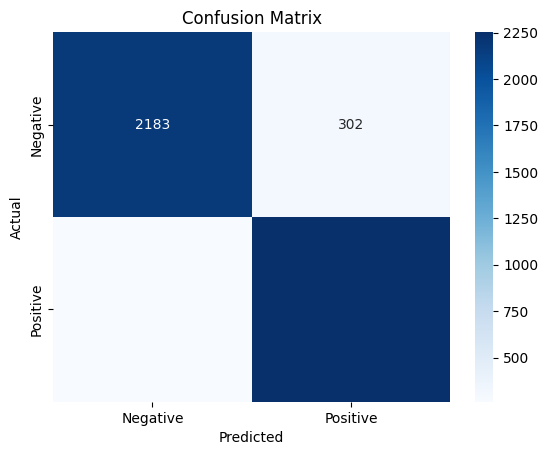

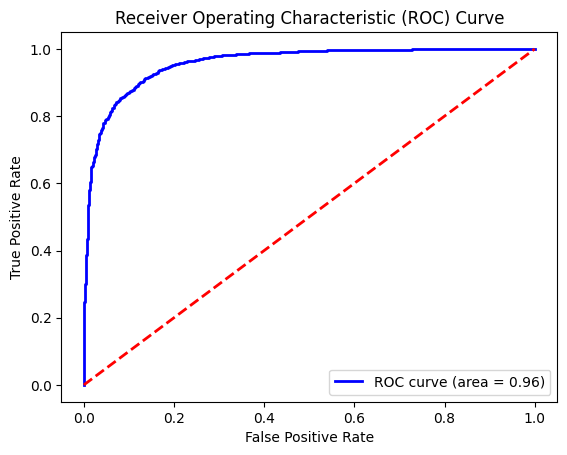

In [4]:
import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Step 1: Download NLTK resources
nltk.download('stopwords')

# Step 2: Load the dataset
def load_data(data_dir):
    reviews = []
    labels = []
    for label in ['pos', 'neg']:
        dir_path = os.path.join(data_dir, label)
        for filename in os.listdir(dir_path):
            with open(os.path.join(dir_path, filename), 'r', encoding='utf-8') as file:
                reviews.append(file.read())
                labels.append(1 if label == 'pos' else 0)
    return pd.DataFrame({'review': reviews, 'label': labels})

# Specify the directory where the dataset is located (after extraction)
data_directory = r"C:\Users\HP\Documents\btp\aclImdb_v1\aclImdb\train"  # Update this path
df = load_data(data_directory)

# Step 3: Data Preprocessing
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove @ mentions
    text = re.sub(r'#', '', text)  # Remove # symbols
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

# Apply the cleaning function
df['review'] = df['review'].apply(clean_text)

# Step 4: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

# Step 5: Convert text data to feature vectors using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Step 6: Model training with hyperparameter tuning
model = LogisticRegression(max_iter=1000)
params = {'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(model, params, cv=5)
grid_search.fit(X_train_vect, y_train)

# Best model
best_model = grid_search.best_estimator_

# Step 7: Make predictions
y_pred = best_model.predict(X_test_vect)

# Step 8: Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test_vect)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
